# B_HIT.sVDJ tutorial

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import B_HIT.sVDJ.tl as tl
from scipy.stats import pearsonr

In [2]:
BcellAggLoc = pd.read_csv('data/BcellAggLocAnno.tsv', sep='\t',index_col=0)
BcellAggLoc = BcellAggLoc[[ 'Bcell_aggregate_label', 'gex_x', 'gex_y', 'gex_Bx', 'gex_By']].copy()
BcellAggLoc['patient'] = BcellAggLoc['Bcell_aggregate_label'].str.split('-').str[0].str.split('_').str[0]
BcellAggLoc['tissue'] = BcellAggLoc['Bcell_aggregate_label'].str.split('-').str[0].str.split('_').str[1]
BcellAggLoc['on'] = BcellAggLoc['patient'].astype(str) + '-' + BcellAggLoc['tissue'].astype(str) +'_' + np.array(BcellAggLoc['gex_Bx'].astype(str)) +'_'+ np.array(BcellAggLoc['gex_By'].astype(str))
BcellAggLoc = BcellAggLoc.drop(['gex_x','gex_y','gex_Bx','gex_By','patient', 'tissue'], axis=1)
BcellAggLoc['BaggArea'] = BcellAggLoc['Bcell_aggregate_label'].map(BcellAggLoc['Bcell_aggregate_label'].value_counts().to_dict()) * 100
BcellAggLoc['Bagg_Anno_res'] = 'B Lymphocytes Aggregate'

In [3]:
rep_file = pd.read_csv('./data/rep2_filtered_loc_3_reg1.data.tsv', sep='\t', index_col=0)
rep_file['on'] = rep_file['sample_xy_orignial_tissueCut_B'].apply(lambda x: '_'.join([x.split('_')[0]] + x.split('_')[-2:])) 
rep_loc = pd.merge(rep_file, BcellAggLoc, on = 'on', how= 'left')  
rep_loc = rep_loc[rep_loc['Cregion_simple'].str.contains('IG')].copy() 

In [4]:
groupby_cols = ['sample', 'Cregion_simple', 'family_id', 'Bcell_aggregate_label']
extra_cols = ['Bx', 'By']
count_col = 'clone'
_Index_compute = tl.compute_clone_counts(rep_loc, groupby_cols, count_col, extra_cols)

rep_agg = rep_loc[groupby_cols + extra_cols + [count_col]].value_counts().reset_index(name='UmiCount')

_Index_compute['cloneRich'] = tl.compute_richness(rep_agg, clone_extra = ['sample', 'family_id', 'clone' ] 
                                                  clone_group = ['Bcell_aggregate_label', 'Cregion_simple'], 
                                                  richness_name = 'cloneRichness')

richness_name = 'cloneFamilyRichness'
cloneFamily_group = ['Bcell_aggregate_label', 'Cregion_simple']
cloneFamily_extra = ['sample', 'family_id']
_Index_compute['cloneFamilyRich'] = tl.compute_richness(rep_agg, cloneFamily_extra, 
                                                        cloneFamily_group, richness_name)

_Index_compute['CDR3nt'] = _Index_compute['clone'].str.split('_').str[0]

In [5]:
_Index_compute.head() 

,sample,Cregion_simple,family_id,Bcell_aggregate_label,clone,freq,count,cloneRich,cloneFamilyRich,CDR3nt
0,P0411-CC,IGH,IGH_family_0,P0411_CC-10,TGTGCGAGACCAGATTTTGATATCGTGACTAATTATTATGGGGGGG...,1.000000,1,2088,253,TGTGCGAGACCAGATTTTGATATCGTGACTAATTATTATGGGGGGG...
1,P0411-CC,IGH,IGH_family_0,P0411_CC-11,TGTGCGAGACCAGATTTTGATATCGTGACTAATTATTATGGGGAGG...,0.500000,1,2088,253,TGTGCGAGACCAGATTTTGATATCGTGACTAATTATTATGGGGAGG...
2,P0411-CC,IGH,IGH_family_0,P0411_CC-11,TGTGCGAGACCAGATTTTGATATCGTGACTAATTATTATGGGGGGG...,0.500000,1,1721,372,TGTGCGAGACCAGATTTTGATATCGTGACTAATTATTATGGGGGGG...
3,P0411-CC,IGH,IGH_family_0,P0411_CC-3,TGTGCGAGACCAGATTTTGATATCGTGACTAATTATTATGGGGGGG...,0.168421,16,1925,223,TGTGCGAGACCAGATTTTGATATCGTGACTAATTATTATGGGGGGG...
4,P0411-CC,IGH,IGH_family_0,P0411_CC-3,TGGGCGAGACCAGATTTTGATATCGTGACTAATTATTATGGGGGGG...,0.052632,5,1925,223,TGGGCGAGACCAGATTTTGATATCGTGACTAATTATTATGGGGGGG...


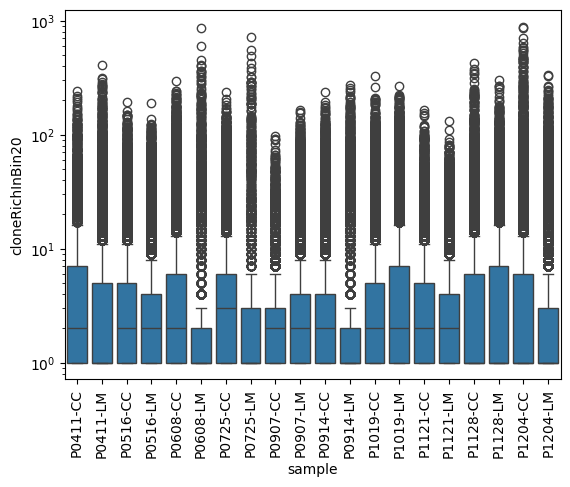

In [6]:
rep_file_stat = rep_file[['sample', 'Cregion_simple', 'clone', 'family_id', 'Bx', 'By' ]].value_counts().reset_index(name='cloneUmiInBin20')
bin20clonecount = rep_file_stat.groupby(['sample', 'Cregion_simple', 'Bx', 'By']).size().reset_index(name='cloneRichInBin20') 
sns.boxplot(data=bin20clonecount, x='sample', y='cloneRichInBin20')
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

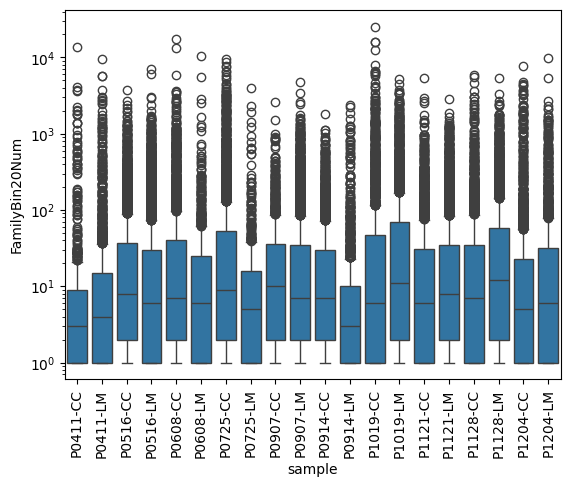

In [7]:
rep_file_stat = rep_file[['sample', 'Cregion_simple', 'clone', 'family_id', 'Bx', 'By' ]].value_counts().reset_index(name='cloneUmiInBin20')
familyBin20Count = rep_file_stat.groupby(['sample', 'Cregion_simple', 'family_id']).size().reset_index(name='FamilyBin20Num') 

sns.boxplot(data=familyBin20Count, x='sample', y='FamilyBin20Num')
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

In [8]:
rep_agg_all = rep_loc.copy() 
rep_agg_all['Bcell_aggregate_label_2'] = np.array(rep_agg_all['Bcell_aggregate_label']) 
rep_agg_all.loc[~rep_agg_all['Bcell_aggregate_label_2'].isna(), 'Bcell_aggregate_label_2'] = 'Aggregates' 
rep_agg_all.loc[rep_agg_all['Bcell_aggregate_label_2'].isna(), 'Bcell_aggregate_label_2'] = 'Scattered' 
rep_agg_all_1 = rep_agg_all[['family_id', 'sample', 'Cregion_simple', 'Bx', 'By']].value_counts().reset_index(name='UmiCount')  
_Index_compute_count = rep_agg_all_1.groupby(['sample', 'Cregion_simple'])['family_id'].value_counts().reset_index(name='bin20Count') 
family_id_dict = _Index_compute_count.set_index(['sample', 'Cregion_simple', 'family_id']).to_dict()['bin20Count'] 
rep_agg_all_1 = rep_agg_all[['sample', 'Cregion_simple', 'family_id', 'Bcell_aggregate_label_2']].drop_duplicates() 
rep_agg_all_1['family_id_bin20Count'] = rep_agg_all_1.apply(lambda row: family_id_dict.get((row['sample'], row['Cregion_simple'], row['family_id'])), axis=1) 

df = rep_agg_all_1.pivot_table(index=['sample', 'Cregion_simple', 'family_id'], columns=['Bcell_aggregate_label_2'])
df.columns = df.columns.get_level_values(1)
df['class'] = 'Not_InAgg'
df.loc[df['Scattered'].isna(),'class'] = 'InAgg'
df.loc[(~df['Scattered'].isna()) & (~df['Aggregates'].isna()), 'class'] = 'Shared' 
df = df.reset_index() 
df['family_id_bin20Count'] = df.apply(lambda row: family_id_dict.get((row['sample'], row['Cregion_simple'], row['family_id'])), axis=1) 
cloneLocClassDict = df[['sample', 'Cregion_simple', 'family_id', 'class']].set_index(['sample', 'Cregion_simple', 'family_id']).to_dict()['class']

rep_agg = rep_loc[['family_id', 'sample', 'Cregion_simple', 'Bx', 'By']].value_counts().reset_index(name='UmiCount') 
rep_agg['familyLocClass'] = rep_agg.apply(lambda row: cloneLocClassDict.get((row['sample'], row['Cregion_simple'], row['family_id'])), axis=1) 
_Index_compute_count = rep_agg.groupby(['sample', 'Cregion_simple', 'familyLocClass'])['family_id'].value_counts().reset_index(name='count')
_Index_compute_freq = rep_agg.groupby(['sample', 'Cregion_simple', 'familyLocClass'])['family_id'].value_counts(normalize=True).reset_index(name='freq') 
_Index_compute = pd.merge(_Index_compute_freq, _Index_compute_count, on = ['sample', 'Cregion_simple', 'familyLocClass', 'family_id']) 

_Index_compute = _Index_compute[~_Index_compute['sample'].str.contains('1204')]

# 变量名是familyLocClass

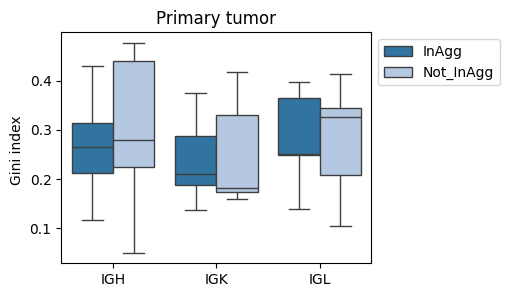

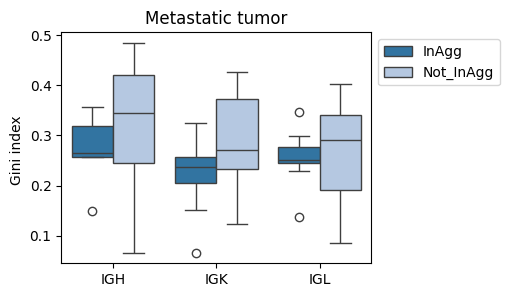

In [9]:
tmp_df = tl.compute_grouped_index(_Index_compute, index = 'gini_index', 
                                  groups = ['sample', 'Cregion_simple','familyLocClass'], 
                                  column_name = 'count', exclude_values=['Shared'], 
                                  exclude_name='familyLocClass')

fig, ax = plt.subplots(1, 1, figsize=(4,3))
sns.boxplot(data=tmp_df[tmp_df['sample'].str.contains('CC')], x='Cregion_simple', y='gini_index', hue='familyLocClass', ax=ax, palette='tab20')   
plt.title('Primary tumor')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('') 
plt.ylabel('Gini index ')   #(clone family)
plt.xticks(rotation=0)
plt.show() 

fig, ax = plt.subplots(1, 1, figsize=(4,3))
sns.boxplot(data=tmp_df[tmp_df['sample'].str.contains('LM')], x='Cregion_simple', y='gini_index', hue='familyLocClass', ax=ax, palette='tab20')   
plt.title('Metastatic tumor')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('') 
plt.ylabel('Gini index ')   #(clone family)
plt.xticks(rotation=0)
plt.show() 

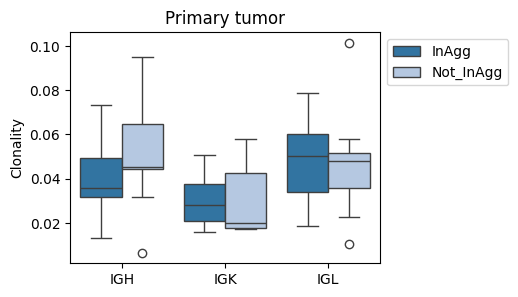

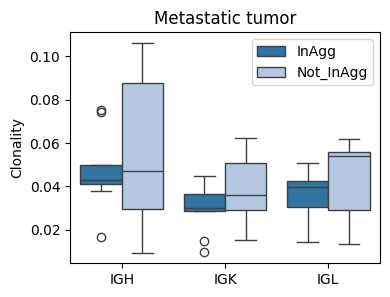

In [10]:
tmp_df = tl.compute_grouped_index(_Index_compute, index = 'Clonality', 
                                  groups = ['sample', 'Cregion_simple','familyLocClass'], 
                                  column_name = 'freq', exclude_values=['Shared'], 
                                  exclude_name='familyLocClass')


fig, ax = plt.subplots(1, 1, figsize=(4,3))
sns.boxplot(data=tmp_df[tmp_df['sample'].str.contains('CC')], x='Cregion_simple', y='Clonality', hue='familyLocClass', ax=ax, palette='tab20')  
plt.legend(bbox_to_anchor=(1,1))
plt.title('Primary tumor')
plt.xlabel('') 
plt.ylabel('Clonality')   #  (clone family)
plt.xticks(rotation=0)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4,3))
sns.boxplot(data=tmp_df[tmp_df['sample'].str.contains('LM')], x='Cregion_simple', y='Clonality', hue='familyLocClass', ax=ax, palette='tab20')  
plt.legend(bbox_to_anchor=(1,1))
plt.title('Metastatic tumor')
plt.xlabel('') 
plt.ylabel('Clonality')   #  (clone family)
plt.xticks(rotation=0)
plt.show()


## Aggrates面积与克隆数量、扩增
### 克隆数量

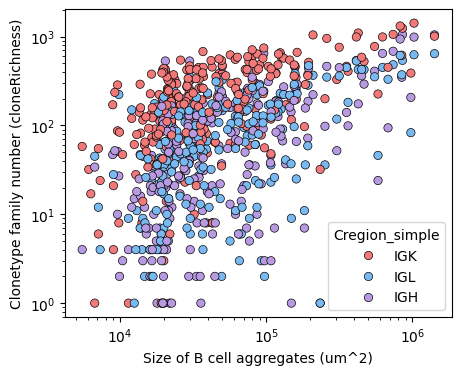

In [11]:
rep_agg = rep_loc[['family_id', 'sample', 'Cregion_simple', 'Bcell_aggregate_label', 'Bagg_Anno_res', 'Bx', 'By', 'BaggArea']].value_counts().reset_index(name='UmiCount') 
cloneRich = tl.compute_richness(df = rep_agg, extra_cols = ['sample', 'family_id'], 
                             groupby_cols = ['Bcell_aggregate_label', 'Bagg_Anno_res', 'BaggArea', 'Cregion_simple'], 
                             richness_name = 'cloneFamilyRichness', default_value=0, return_df=True)

plt.figure(figsize=(5,4))
sns.scatterplot(x='BaggArea', y='cloneFamilyRichness', data=cloneRich, hue='Cregion_simple', palette={'IGH':'#B89AE3', 'IGK':'#f27979', 'IGL':'#79b9f2'}, edgecolor='black' ) 
plt.yscale('log') 
plt.xscale('log') 
plt.xlabel('Size of B cell aggregates (um^2)') 
plt.ylabel('Clonetype family number (cloneRichness)') 
plt.show()

In [13]:
cloneRich['tissue'] = cloneRich['Bcell_aggregate_label'].str.split('-').str[0].str.split('_').str[1]
corrDf = tl.compute_correlation(cloneRich, groupby_cols = ['Cregion_simple','tissue'], 
                                corr1 = 'BaggArea', corr2 = 'cloneFamilyRichness', 
                                save=False, path=None, compute_corr_matrix=False)

### 扩增

In [15]:
_Index_compute = tl.compute_clone_counts(rep_loc, groupby_cols = ['sample', 'Cregion_simple', 'Bcell_aggregate_label','Bagg_Anno_res', 'BaggArea'], 
                                         count_col = 'family_id', extra_cols =['Bx', 'By'], 
                                         count_name='count', freq_name='freq', if_count=True, if_freq=True)

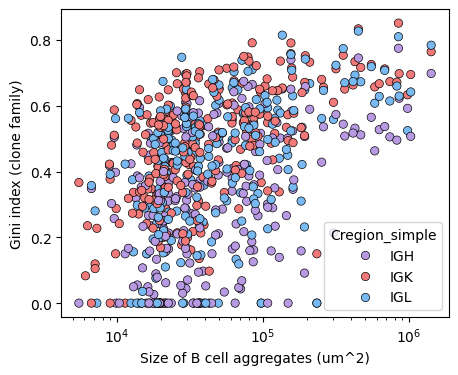

In [16]:
tmp_df = tl.compute_grouped_index(_Index_compute, index = 'gini_index', groups = ['sample', 'Cregion_simple', 'Bcell_aggregate_label', 'Bagg_Anno_res','BaggArea'], 
                                 column_name = 'count', exclude_values=None, exclude_name=None, check_column=None)

plt.figure(figsize=(5,4)) 
sns.scatterplot(x='BaggArea', y='gini_index', data=tmp_df, hue='Cregion_simple', palette={'IGH':'#B89AE3', 'IGK':'#f27979', 'IGL':'#79b9f2'}, edgecolor='black' )  
plt.xscale('log')
plt.xlabel('Size of B cell aggregates (um^2)') 
plt.ylabel('Gini index (clone family)')  
plt.show()

In [20]:
tmp_df['tissue'] = tmp_df['sample'].str.split('-').str[1]

corrDf, corrmat, Pmat = tl.compute_correlation(cloneRich = tmp_df, groupby_cols =['Cregion_simple','tissue'], 
                                               corr1 = 'BaggArea', corr2 = 'gini_index', save=False, 
                                               path=None, compute_corr_matrix=True)

print(corrmat)

region        CC        LM
chain                     
IGH     0.341936  0.398674
IGK     0.370056  0.441915
IGL     0.362810  0.418741


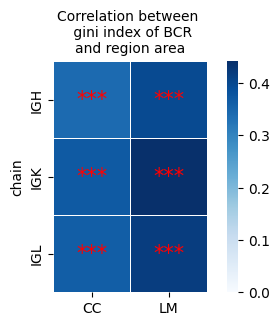

In [19]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(corrmat, annot=False, fmt=".2f",vmin=0,  square=True, linewidths=0.5, ax=ax, cmap='Blues') 
for i in range(corrmat.shape[0]):
    for j in range(corrmat.shape[1]):
        x, y = j + 0.5, i + 0.5 
        if Pmat.iloc[i, j] < 0.001:  # FDR > 0.1
            ax.text(x, y, "***", ha="center", va="center", color="red", fontsize=15)
        elif Pmat.iloc[i, j] < 0.01: 
            ax.text(x, y, "**", ha="center", va="center", color="red", fontsize=15)
        elif Pmat.iloc[i, j] < 0.05: 
            ax.text(x, y, "*", ha="center", va="center", color="red", fontsize=15)
plt.title('Correlation between \n gini index of BCR\nand region area', fontsize=10)
plt.xlabel('')
plt.show()

### clonal diversification index

In [22]:
groupby_cols = ['sample', 'Cregion_simple', 'family_id','Bcell_aggregate_label', 'Bagg_Anno_res','BaggArea']
extra_cols = ['Bx', 'By']
count_col = 'clone'
_Index_compute = tl.compute_clone_counts(rep_loc, groupby_cols, count_col, extra_cols)


_family_Index_compute = _Index_compute.copy()
_family_Index_compute = _family_Index_compute[['sample', 'Cregion_simple', 'family_id', 'clone', 'Bcell_aggregate_label', 'Bagg_Anno_res', 'BaggArea' ]].drop_duplicates()
_family_Index_compute = _family_Index_compute.groupby(['sample', 'Cregion_simple', 'Bcell_aggregate_label', 'Bagg_Anno_res', 'BaggArea'])['family_id'].value_counts().reset_index(name='count')  


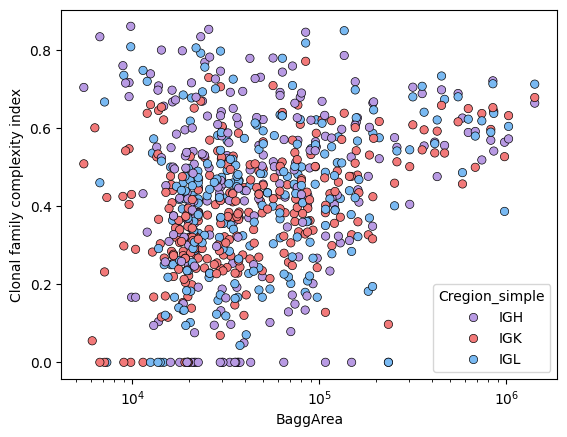

In [24]:
tmp_df = tl.compute_grouped_index(_family_Index_compute, index = 'gini_index', groups = ['sample', 'Cregion_simple', 'Bcell_aggregate_label', 'Bagg_Anno_res', 'BaggArea'], 
                                  column_name = 'count', exclude_values=None, exclude_name=None, check_column='Clonal_diversification')
tmp_df['tissue'] = tmp_df['sample'].str.split('-').str[1]


sns.scatterplot(data=tmp_df, x='BaggArea', y='Clonal_diversification', hue='Cregion_simple', palette={'IGH':'#B89AE3', 'IGK':'#f27979', 'IGL':'#79b9f2'}, edgecolor='black') 
plt.ylabel('Clonal family complexity index')
plt.xscale('log')
plt.show()

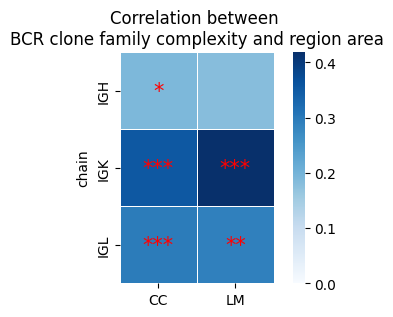

In [25]:
corrDf, corrmat, Pmat = tl.compute_correlation(cloneRich = tmp_df, groupby_cols = ['Cregion_simple','tissue'], 
                                               corr1 = 'BaggArea', corr2 = 'Clonal_diversification', 
                                               save=False, path=None, compute_corr_matrix=True)


fig, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(corrmat, annot=False, fmt=".2f",vmin=0,  square=True, linewidths=0.5, ax=ax, cmap='Blues')
for i in range(corrmat.shape[0]):
    for j in range(corrmat.shape[1]):
        x, y = j + 0.5, i + 0.5  # 每个方块的中心点
        if Pmat.iloc[i, j] < 0.001:  # FDR > 0.1
            ax.text(x, y, "***", ha="center", va="center", color="red", fontsize=15)
        elif Pmat.iloc[i, j] < 0.01: 
            ax.text(x, y, "**", ha="center", va="center", color="red", fontsize=15)
        elif Pmat.iloc[i, j] < 0.05: 
            ax.text(x, y, "*", ha="center", va="center", color="red", fontsize=15)
plt.title('Correlation between \nBCR clone family complexity and region area', fontsize=12)
plt.xlabel('')
plt.show()